In [1]:
import numpy as np

from lightonml.projections.sklearn import OPUMap
#from lightonopu.opu i|mport OPU
import time 
import os
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import math

import h5py
from tqdm import tqdm

In [51]:
f_train_raw = h5py.File("../Data/train.h5", 'r')
f_test_raw = h5py.File("../Data/test.h5",'r')

f_train_bin = h5py.File("../BinaryData/3bits4binstrain.h5", 'r')
f_test_bin = h5py.File("../BinaryData/3bits4binstest.h5", 'r')

In [52]:
num_bin_img = 10000
num_raw_img = num_bin_img

In [54]:

X_train_bin = f_train_bin['inputs'][:num_bin_img]
X_test_bin = f_test_bin['inputs'][:]

X_train_raw = f_train_raw['all_events']['hist'][:num_raw_img]
X_test_raw = f_test_raw['all_events']['hist'][:]

y_train_bin = f_train_raw['all_events']['y'][:num_raw_img]
y_test_bin = f_test_raw['all_events']['y'][:]

weights_train = f_train_raw['all_events']['weight'][:num_raw_img]
weights_test = f_test_raw['all_events']['weight'][:]

In [3]:
print(X_test_bin.shape)

(137471, 12288)


In [4]:
print(X_train_bin.shape)
print(X_test_bin.shape)

(4096, 12288)
(137471, 12288)


In [ ]:
#X_train_bin[10][10]

# Weights processing

In [5]:
print(np.sum(np.log(weights_train[y_train_bin==0]+1)))

16747.086002788492


In [6]:
print(np.sum(np.log(weights_train[y_train_bin==1]+1)))

11187.317454369148


# Create OPU features

In [ ]:
since = time.time()
n_components = 17000 #32*32
opu_mapping = OPUMap(n_components=n_components)
train_random_features = opu_mapping.transform(X_train_bin[:])
print('train set done')
test_random_features = opu_mapping.transform(X_test_bin[:])
print('test set done')
projection_time = time.time() - since

print('Time taken by RP on OPU: {:.4f} s'.format(projection_time))

In [ ]:
test_random_features.shape

In [ ]:
y_train_bin.shape

## Save random features

In [ ]:
hf_train = h5py.File("../RandomFeatures/3bits4binstrain_shifted.h5","w")
hf_train.create_dataset("inputs",data=train_random_features)
hf_train.create_dataset("labels",data=y_train_bin)
hf_train.create_dataset("weights",data=weights_train)
hf_train.close()

In [ ]:
hf_test = h5py.File("../RandomFeatures/3bits4bintest_shifted.h5","w")
hf_test.create_dataset("inputs",data=test_random_features)
hf_test.create_dataset("labels",data=y_test_bin)
hf_test.create_dataset("weights",data=weights_test)
hf_test.close()

In [ ]:
#min_max = preprocessing.MinMaxScaler()
#min_max.fit_transform(train_random_features)
#min_max.transform(test_random_features)

# Load saved data

In [7]:
number_of_images_to_use = 100000
number_of_features_to_use =50000

In [8]:
f_train = h5py.File("../RandomFeatures/3bits4binstrain.h5", 'r')
f_test = h5py.File("../RandomFeatures/3bits4bintest.h5",'r')

train_random_features = f_train['inputs'][:number_of_images_to_use,:number_of_features_to_use]
y_train_bin = f_train['labels'][:number_of_images_to_use]
weights_train = f_train['weights'][:number_of_images_to_use]

test_random_features = f_test['inputs'][:,:number_of_features_to_use]
y_test_bin = f_test['labels'][:]
weights_test = f_test['weights'][:]

f_train.close()
f_test.close()

In [9]:
f_train_raw = h5py.File("../Data/train.h5", 'r')
f_test_raw = h5py.File("../Data/test.h5",'r')

passSR_train = f_train_raw['all_events']['passSR'][:number_of_images_to_use]
passSR_test = f_test_raw['all_events']['passSR'][:]

In [10]:
print(train_random_features.shape)
print(y_train_bin.shape)

(100000, 17000)
(100000,)


# Ridge classifier

In [11]:
log_weights = np.log10(weights_train)
log_weights[np.isinf(log_weights)]=0
log_weights[log_weights<0]=0
for i in range(train_random_features.shape[0]):
    print(weights_train[i])
    print(y_train_bin[i])

1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
0.17838
0.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
153.68399999999997
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0


516.96
1.0
56340.00000000001
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
71892000.0
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
0.17838
0.0
0.0029142
0.0
516.96
1.0
5.7672
0.0
0.17838
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
1.2114e-05
0.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
0.002914

516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
4222.8
0.0
153.68399999999997
0.0
56340.00000000001
0.0
0.0029142
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
4222.8
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
0.17838
0.0
0.0029142
0.0
0.17838
0.0
4222.8
0.0
0.17

516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
4222.8
0.0
71892000.0
0.0
0.0029142
0.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
0.0029142
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
5.7672
0.0
516.96
1.0
0.17838
0.0
0.17838
0.0
516.96
1.0
0.0029142
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
5.7672
0.0
5.7672
0.0
0.0029142
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
71892000.0
0.0
516.96

1.0
516.96
1.0
153.68399999999997
0.0
71892000.0
0.0
5.7672
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
0.17838
0.0
153.68399999999997
0.0
4222.8
0.0
56340.00000000001
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
71892000.0
0.0
5.7672
0.0
5.7672
0.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
5.7672
0.0
153.68399999999997
0.0
1.2114e-05
0.0
0.0029142
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
0.17838
0.0
4222.8
0.0
56340.00000000001
0.0
5.7672
0.0
56340.00000000001
0.0
563

1.0
153.68399999999997
0.0
1.2114e-05
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
1.2114e-05
0.0
0.0029142
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
71892000.0
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
0.0029142
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
5.7672
0.0
0.17838
0.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.

56340.00000000001
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
4222.8
0.0
4222.8
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
153.68399999999997
0.0
0.1

0.0
153.68399999999997
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
71892000.0
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
1.2114e-05
0.0
0.17838
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
153.68399999999997
0.0
0.17838
0.0
516.96
1.0
71892000.0
0.0
1.2114e-05
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
4222.8
0.0
0.0029142
0.0
1489679.9999999998
0.0
5.7672
0.0
71892000.0
0.0
153.68399999999997
0.0
516.96
1.0
0.17838
0.0
1.2114e-05
0.0
5.7672
0.0
56340.00000000001
0.0
56340.00000000001
0.0
5.7672
0.0
0.0029142
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
51

516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
5.7672
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
71892000.0
0.0
14

1.0
4222.8
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
5.7672
0.0
0.17838
0.0
5.7672
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
56340.00000000001
0.0
5.7672
0.0
153.68399999999997
0.0
51

1489679.9999999998
0.0
1489679.9999999998
0.0
4222.8
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
4222.8
0.0
0.0029142
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
4222.8
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
71892000.0
0.0
4222.8
0.0
1.2114e-05
0.0
153.68399999999997
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
0.0029142
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029

71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
4222.8
0.0
5.7672
0.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
4222.8
0.0
0.0029142
0.0
71892000.0
0.0
516.96
1.0
5.7672
0.0
0.0029142
0.0
153.68399999999997
0.0
5.7672
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
0.0029142
0.0
4222.8
0.0
56340.00000000001
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
71892000.0
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
0.17838
0.0
153.68399999999997
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
0.0029142


1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
0.0029142
0.0
4222.8
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
4222.8
0.0
4222.8
0.0
1489679.9999999998
0.0
71892000.0
0.0
71892000.0
0.0
516.96
1.0
1489679.9999999998
0.0
1.2114e-05
0.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
56340.00000000001
0.0
5.7672
0.0
516.96
1.0
4222.8
0.0
516

1.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
1.2114e-05
0.0
4222.8
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
71892000.0
0.0
0.17838
0.0
516.96
1.0
0.0029142
0.0
4222.8
0.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
0.0029142
0.0
5.7672
0.0
5914800000.0
0.0
0.17838
0.0
0.0029142
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
15

516.96
1.0
0.17838
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
71892000.0
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
0.17838
0.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
0.17838
0.0
0.0029142
0.0
1.2114e-05
0.0
516.96
1.0
153.68399

516.96
1.0
5.7672
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
0.17838
0.0
516.96
1.0
4222.8
0.0
5914800000.0
0.0
71892000.0
0.0
1489679.9999999998
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
71892000.0
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
56340.00000000001
0.0
0.0029142
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
71892000.0
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1.2114e-05
0.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
71892000.0
0.0
1.2114e-05
0.0
1.2114e-05
0.0
516.96
1.0
71892000.0
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0

0.0
56340.00000000001
0.0
0.0029142
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
153.68399999999997
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
0.17838
0.0
1489679.9999999998
0.0
4222.8
0.0
1489679.9999999998
0.0
4222.8
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
0.17838
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
0.0029142
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
0.17838
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
56340.0000000000

0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
5.7672
0.0
0.17838
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
1489679.9999999998
0.0
1.2114e-05
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
4222.8
0.0
71892000.0
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
153.68399999999997
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
0.17838
0.0
0.0029142
0.0
0.0029142
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
0.0029142
0.0
5.7672
0.0
0.17838
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
14

1.0
5.7672
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
1.2114e-05
0.0
516.96
1.0
153.68399999999997
0.0
71892000.0
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
0.17838
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
0.17838
0.0
0.17838
0.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
5

1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
71892000.0
0.0
4222.8
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
0.0029142
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
1.2114e-05
0.0
516.96
1.0
0.0029142
0.0
0.0029142
0.0
5.7672
0.0
56340.00000000001
0.0
0.17838
0.0
0.17838
0.0
0.0029142
0.0
5.7672
0.0
0.0029142
0.0
0.17838
0.0
1.2114e-05
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
153.68399999999997
0.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
56340.000000

516.96
1.0
0.17838
0.0
0.17838
0.0
4222.8
0.0
5.7672
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
5.7672
0.0
0.17838
0.0
1.2114e-05
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
0.17838
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
0.17838
0.0
5.7672
0.0
71892000.0
0.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
0.0029142
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
1.2114e-05
0.0
516.96
1.0
153.68399999999

0.0
56340.00000000001
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
153.68399999999997
0.0
1.2114e-05
0.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1.2114e-05
0.0
5914800000.0
0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
56340.00000000001
0.0
71892000.0
0.0
516.96
1.0
0.0029142
0.0
153.68399999999997
0.0
516.96
1.0
1.2114e-05
0.0
0.0029142
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
5.7672
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
56340.00000000001
0.0
56340.00000000001
0.0
0.17838
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
5.7672
0.0
516.

516.96
1.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
0.17838
0.0
153.68399999999997
0.0
0.17838
0.0
71892000.0
0.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
0.0029142
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
4222.8
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997

4222.8
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
1.2114e-05
0.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
0.0029142
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
0.0029142
0.0
71892000.0
0.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
153.6839999

1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
4222.8
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
56340.00000000001
0.0
153.68399999999997
0.0
0.0029142
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
5.7672
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
1489679.9999999998
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.9

0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
1.2114e-05
0.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
0.0029142
0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
0.17838
0.0
0.0029142
0.0
71892000.0
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
0.0029142
0.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
4222.8
0.0
1.2114e-05
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
153.68399999999997
0.0
4222.8
0.0
71892000.0
0.0
516.96
1.0
1.2114e-05
0.0
1.2114e

516.96
1.0
0.0029142
0.0
4222.8
0.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
153.68399999999997
0.0
5.7672
0.0
516.96
1.0
0.17838
0.0
5.7672
0.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
153.68399999999997
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
0.17838
0.0
1489679.9999999998

5.7672
0.0
71892000.0
0.0
0.17838
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
71892000.0
0.0
71892000.0
0.0
4222.8
0.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
0.17838
0.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
1.2114e-05
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1

0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
4222.8
0.0
0.0029142
0.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
1.2114e-05
0.0
5.7672
0.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
0.17838
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
153.68399999999997
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
4222.8
0.0
71892000.0
0.0
5.7672
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000

1.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
0.0029142
0.0
153.68399999999997
0.0
56340.00000000001
0.0
56340.00000000001
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
71892000.0
0.0
56340.00000000001
0.0
153.68399999999997
0.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
0.17838
0.0
0.0029142
0.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
71892000.0
0.0
4222.8
0.0
0.0029142
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
71892000.0
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
56340.00000000001
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
71892000.0
0.0
153.68399999999997
0.0
516.96

516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
4222.8
0.0
0.17838
0.0
516.96
1.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
4222.8
0.0
153.68399999999997
0.0
1.2114e-05
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
153.68399999999997
0.0
5.7672
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
56340.00000000001
0

1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
0.0029142
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
1.2114e-05
0.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
5.7672
0.0
71892000.0
0.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
4222.8
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
71892000.0
0.0
0.0029142
0.0
5.7

0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
71892000.0
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
71892000.0
0.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
5.7672
0.0
516.96
1.0
1.2114e-05
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
5.7672
0.0
516.96
1.0
71892000.0
0.0
5.7672
0.0
516.96
1.0
5.76

1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
4222.8
0.0
4222.8
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
5.7672
0.0
153.68399999999997
0.0
71892000.0
0.0
71892000.0
0.0
0.17838
0.0
71892000.0
0.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
0.17838
0.0
0.0029142
0.0
516.96
1.0
71892000.0
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.9

0.17838
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
71892000.0
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
5.7672
0.0
5.7672
0.0
1489679.9999999998
0.0
71892000.0
0.0
516.96
1.0
56340.00000000001
0.0
0.0029142
0.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
0.0029142
0.0
0.0029142
0.0
4222.8
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0


1.2114e-05
0.0
0.17838
0.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
5.7672
0.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
0.0029142
0.0
71892000.0
0.0
516.96
1.0
0.0029142
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
0.17838
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
0.0029142
0.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
148

0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
1.2114e-05
0.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
0.0029142
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
0.0029142
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
56340.00000000001
0.0
5.7672
0.0
0.17838
0.0
0.17838
0.0
4222.8
0.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
5.7672
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
1.2114e-05
0.0
516.96
1.0
0.17838
0.0


0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
0.17838
0.0
153.68399999999997
0.0
4222.8
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
0.17838
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
0.0029142
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
0.17838
0.0
1.2114e-05
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516

516.96
1.0
4222.8
0.0
0.0029142
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
0.0029142
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
5.7672
0.0
0.0029142
0.0
1.2114e-05
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
1.2114e-05
0.0
516.96
1.0
71892000.0
0.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
0.0029142
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96

516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
0.0029142
0.0
153.68399999999997
0.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
153.68399999999997
0.0
516.96
1.0
71892000.0
0.0
153.68399999999997
0.0
516.96
1.0
71892000.0
0.0
1.2114e-05
0.0
153.68399999999997
0.0
0.17838
0.0
71892000.0
0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
4222.8
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
14

0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
56340.00000000001
0.0
153.68399999999997
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
71892000.0
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
71892000.0
0.0
1489679.9999999998
0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
4222.8
0.0
0.17838
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
71892000.0
0.0
1489679.9999999998
0.0
15

0.0029142
0.0
4222.8
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
71892000.0
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
1.2114e-05
0.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
1.2114e-05
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
0.0029142
0.0
0.17838
0.0
153.68399999999997
0.0

4222.8
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
71892000.0
0.0
1489679.9999999998
0.0
1.2114e-05
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
0.17838
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
0.0029142
0.0
1.2114e-05
0.0
516.96
1.0
4222.8
0.0
71892000.0
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
5.7672
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
153.68399999999997
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.9

516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
0.17838
0.0
1.2114e-05
0.0
5.7672
0.0
0.0029142
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
1.2114e-05
0.0
5.7672
0.0
0.17838
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.6839

0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
5.7672
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
0.17838
0.0
1.2114e-05
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
4222.8
0.0
4222.8
0.0
0.17838
0.0
516.96
1.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
1.2114e-05
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
0.17838
0.0
516.9

1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
71892000.0
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
71892000.0
0.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
0.17838
0.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
1489679.9

516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
4222.8
0.0
56340.00000000001
0.0
71892000.0
0.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
0.17838
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
0.17838
0.0
516.9

516.96
1.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
153.68399999999997
0.0
71892000.0
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
0.0029142
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
0.17838
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
56340.00000000001
0.0
4222.8
0.0
71892000.0
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
1.2114e-05
0.0
153.68399999999997
0.0
153.68399999999997


1.0
153.68399999999997
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
4222.8
0.0
0.0029142
0.0
56340.00000000001
0.0
56340.00000000001
0.0
71892000.0
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
1.2114e-05
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
71892000.0
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
5.7672
0.0
1.2114e-05
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
56340.00000000001
0.0
5.7672
0.0
1489679.9999999998
0.0
153.6839999999999

0.0
4222.8
0.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
0.17838
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
4222.8
0.0
5.7672
0.0
4222.8
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
0.0029142
0.0
56340.00000000001
0.0
153.68399999999997
0.0
153.68399999999997
0.0
4222.8
0.0
0.17838
0.0
153.68399999999997
0.0
1.2114e-05
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0

5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
0.17838
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
1.2114e-05
0.0
153.68399999999997
0.0
516.96
1.0
0.17838
0.0
4222.8
0.0
5.7672
0.0
71892000.0
0.0
0.17838
0.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
0.17838
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
56340.0000000

5.7672
0.0
516.96
1.0
0.0029142
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
1.2114e-05
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
0.0029142
0.0
1489679.9999999998
0.0
0.17838
0.0
5.7672
0.0
0.17838
0.0
153.68399999999997
0.0
56340.00000000001
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
0.1783

0.0
516.96
1.0
1.2114e-05
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
1.2114e-05
0.0
0.0029142
0.0
516.96
1.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
1.2114e-05
0.0
56340.00000000001
0.0
4222.8
0.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
0.0029142
0.0
516.96
1.0
516.96

0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
516.96
1.0
5.7672
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
0.0029142
0.0
71892000.0
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
0.17838
0.0
4222.8
0.0
516.96
1.0
0.0029142
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
71892000.0
0.0
0.0029142
0.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
1.2114e-05
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
1489679.99999

0.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
71892000.0
0.0
1489679.9999999998
0.0
4222.8
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
0.0029142
0.0
516.96
1.0
0.0029142
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
42

516.96
1.0
71892000.0
0.0
516.96
1.0
1.2114e-05
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
0.0029142
0.0
71892000.0
0.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
1.2114e-05
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
71892000.0
0.0
56340.00000000001
0.0
5.7672
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
0.0029142
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
0.0029142

0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
5.7672
0.0
56340.00000000001
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
5.7672
0.0
56340.00000000001
0.0
153.68399999999997
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
0.0029142
0.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
0.17838
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
56340.00000000001
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
1.2114e-05
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
516.96
1.0


0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
0.17838
0.0
153.68399999999997
0.0
5.7672
0.0
5.7672
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
56340.00000000001
0.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
153.68399999999997
0.0
4222.8
0.0
153.68399999999997
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.17838
0.0
153.68399999999997
0.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
4222.8
0.0
5.7672
0.0
1489679.9999999998
0.0
4222.8
0.0
0.17838
0.0
56340.00000000001
0.0
153.68399999999997
0.0
4222.8
0.0
56340.00000000001
0.0
0.0029142
0.0
5634

5.7672
0.0
4222.8
0.0
5.7672
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
0.0029142
0.0
5.7672
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
1489679.9999999998
0.0
0.0029142
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
153.68399999999997
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
4222.8
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
0.17838
0.0
516.96
1.0
1489679.9999999998
0.0
5.7672
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
5.7672
0.0
516.96
1.0
1.2114e-05
0.0
516.96
1.0
0.17838
0

5.7672
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
56340.00000000001
0.0
1.2114e-05
0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
153.68399999999997
0.0
1.2114e-05
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
0.17838
0.0
56340.00000000001
0.0
153.68399999999997
0.0
516.96
1.0
1.2114e-05
0.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
71892000.0
0.0
56340.00000000001
0.0
153.68399999999997
0.0
4222.8
0.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
0.0029142
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
153.68399999999997
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998


0.0
516.96
1.0
4222.8
0.0
71892000.0
0.0
0.17838
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
0.0029142
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
0.0029142
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
422

516.96
1.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
153.68399999999997
0.0
0.17838
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
71892000.0
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
4222.8
0.0
56340.00000000001
0.0
4222.8
0.0
4222.8
0.0
0.17838
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
71892000.0
0.0
0.17838
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
5.7672
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0

5.7672
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
71892000.0
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
0.0029142
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
71892000.0
0.0
71892000.0
0.0
153.68399999999997
0.0
0.0029142
0.0
56340.00000000001
0.0
4222.8
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
0.17838
0.0
56340.00000000001
0.0
4222.8
0.0
5.7672
0.0
71892000.0
0.0
1489679.9999999998
0.0
516.96
1.0
5.7672
0.0
1

56340.00000000001
0.0
71892000.0
0.0
153.68399999999997
0.0
71892000.0
0.0
0.17838
0.0
71892000.0
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
153.68399999999997
0.0
5.7672
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
153.68399999999997
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
4222.8
0.0
5.7672
0.0
0.0029142
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
4222

1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
4222.8
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
0.17838
0.0
1489679.9999999998
0.0
1489679.9999999998
0.0
516.96
1.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
0.0029142
0.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
0.17838
0.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
1489679.9999999998
0.0
4222.8
0.0
5.7672
0.0
516.96
1.0
153.68399999999997
0.0
0.17838
0.0
5.7672
0.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
56340.00000000001
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
5.7672
0.0
1489679.9999999998
0.0
516.96
1.0
516.

1.0
0.0029142
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
0.17838
0.0
516.96
1.0
516.96
1.0
0.0029142
0.0
516.96
1.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
0.0029142
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
5.7672
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
5.7672
0.0
71892000.0
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
1489679.9999999998
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
4222.8
0.0
56340.00000000001
0.0


0.17838
0.0
516.96
1.0
153.68399999999997
0.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
153.68399999999997
0.0
1.2114e-05
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
1489679.9999999998
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
5.7672
0.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
1489679.9999999998
0.0
153.68399999999997
0.0
516.96
1.0
56340.00000000001
0.0
56340.00000000001
0.0
1.2114e-05
0.0
56340.00000000001
0.0
56340.00000000001
0.0
5.7672
0.0
1.2114e-05
0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
516.96
1.0
516.96
1.0
516.96
1.0
56340.00000000001
0.0
516.96
1.0
56340.00000000001
0.0
4222.8
0.0
56340.00000000001
0.0
516.96
1.0
516.96
1.0
0.17838
0.0
1.2114e-05
0.0
56340.00000000001
0.0
5

0.0
516.96
1.0
153.68399999999997
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
4222.8
0.0
516.96
1.0
4222.8
0.0
516.96
1.0
516.96
1.0
1.2114e-05
0.0
56340.00000000001
0.0
5.7672
0.0
56340.00000000001
0.0
4222.8
0.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
516.96
1.0
56340.00000000001
0.0
5.7672
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
4222.8
0.0
153.68399999999997
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
71892000.0
0.0
1489679.9999999998
0.0
0.17838
0.0
516.96
1.0
0.17838
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
71892000.0
0.0
56340.00000000001
0.0
516.96
1.0
4222.8
0.0
5.7672
0.0
1489679.9999999998
0.0
4222.8
0.0
516.96
1.0
5.7672
0.0
516.96
1.0
516.96
1.0
153.68399999999997
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
71892000.0
0.0
516.96
1.0
4222.8
0.0
1489679.9999999998
0.0
56340.00000000001
0.0
5.7672
0.0
516.96
1.0
71892000.0
0.0
516.96
1.0
516.96
1.0
4222.8
0.0
1.2114e-05
0.0
71892000.0
0.0
516.96
1.0
516.96
1.0
516.96
1.0
4222.

In [12]:
ridge_opu = RidgeClassifier(alpha=10,copy_X=True)
#since = time.time()
ridge_opu.fit(train_random_features[:,:number_of_features_to_use], y_train_bin)

RidgeClassifier(alpha=10, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [13]:
train_accuracy = ridge_opu.score(train_random_features[:number_of_images_to_use,:number_of_features_to_use], y_train_bin[:number_of_images_to_use])
test_accuracy = ridge_opu.score(test_random_features[:,:number_of_features_to_use], y_test_bin)
#score_time = time.time() - since
#print('Time for score: {:.4f} s'.format(score_time))
print('OPU Train accuracy (%): {:.4f}'.format(train_accuracy*100))
print('OPU Test accuracy (%): {:.4f}'.format(test_accuracy*100))

OPU Train accuracy (%): 92.2900
OPU Test accuracy (%): 85.0979


### ROC plot

In [15]:
test_output_opu = ridge_opu.decision_function(test_random_features[:,:number_of_features_to_use])
#minMaxScaler = preprocessing.MinMaxScaler()
#test_output_opu=test_output_opu.reshape(1, -1)
#minMaxScaler.fit_transform(test_output_opu)
#test_output_opu=test_output_opu.flatten()
prediction_opu =ridge_opu.predict(test_random_features[:,:number_of_features_to_use])

In [16]:
fpr_opu, tpr_opu, thresholds = metrics.roc_curve(y_test_bin,test_output_opu,sample_weight=weights_test)

Text(0, 0.5, 'tpr')

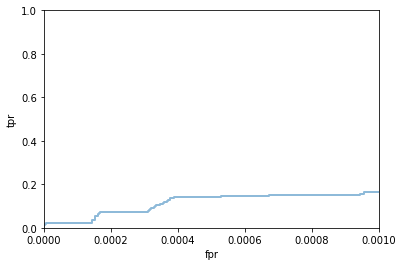

In [17]:
pyplot.plot(fpr_opu, tpr_opu, lw=2,alpha=0.5)
pyplot.axis((0,.001,0,1))
pyplot.xlabel("fpr")
pyplot.ylabel("tpr")
#pyplot.title("")
#pyplot.savefig("using physics cuts")


In [18]:
metrics.auc(fpr_opu, tpr_opu)

0.9316124598752578

In [19]:
train_output_opu = ridge_opu.decision_function(train_random_features[:,:number_of_features_to_use])

In [20]:
print(train_output_opu.shape)

(100000,)


In [21]:
#np.save("../Results/BDT_24th_feature_train_4096",train_output_opu)

In [22]:
#np.save("../Results/BDT_24th_feature_test_4096",test_output_opu)

In [23]:
metrics.roc_auc_score(y_test_bin,passSR_test,sample_weight=weights_test)

0.7110808681163782

## Plot the scores

In [24]:
train_output_opu = ridge_opu.decision_function(train_random_features[:,:number_of_features_to_use])

### test set score

In [25]:
test_output_opu = ridge_opu.decision_function(test_random_features[:,:number_of_features_to_use])

## PLOT OUTPUT

In [26]:
def compare_train_test(y_pred_train, y_train, y_pred, y_test, high_low=(0,1), bins=30):
    pyplot.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', normed=True,
                 label='S (train)') # alpha is transparancy
    pyplot.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', normed=True,
                 label='B (train)')

    hist, bins = np.histogram(
        y_pred[y_test == 1], 
                              bins=bins, range=high_low, 
                                   normed=True)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    pyplot.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, normed=True)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    pyplot.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    pyplot.xlabel("scores for 50000")
    pyplot.ylabel("Arbitrary units")
    pyplot.legend(loc='best')
    
    #pyplot.savefig("scores plot 50000")

In [27]:
print(train_output_opu.reshape(-1,1).shape)
y_tr = y_train_bin[:number_of_images_to_use]

(100000, 1)


/data1/alpha/biswajit-biswas/opu-venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/data1/alpha/biswajit-biswas/opu-venv/lib/python3.5/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/data1/alpha/biswajit-biswas/opu-venv/lib/python3.5/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result

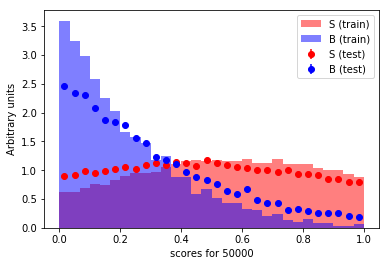

In [28]:
compare_train_test(np.array(train_output_opu).reshape(-1,1) , y_tr , np.array(test_output_opu).reshape(-1,1) , y_test_bin)

### Plot the AUC curve against number of random features

In [29]:
#ADD WEIGHTS

def Plot_AUC_against_RF(train_random_features, test_random_features, y_train_bin, y_test_bin, batch_step=5000, random_step=200, number_of_curves=10, max_rf_step=100, tolerance=3):

    #batch_step: the size of steps in which the number of training data increases
    #ramdam_step: the size of steps in which the number of random features used increases after each iteration
    #number_of_curves: number of training samples of different sizes
    #max_rf_step: max size of the training size = batch_step*max_rf_step
    #tolerance: number of consecutive steps of decreasing AUC before stopping the curve
    
    AUC_max=[0]*number_of_curves
    AUC_max_loc = [0]*number_of_curves

    for j in range(1,number_of_curves+1):

        numberOfVectors = [] 
        AUC_test = [] 
        AUC_train = [] 

        for i in range (1,max_rf_step+1):

            #print(i)
            n_components = random_step*i #32*3
            #projection_time = time.time() - since
            #print('Time taken by RP on OPU: {:.4f} s'.format(projection_time))

            clf = RidgeClassifier(alpha=10)
            #since = time.time()
            clf.fit(train_random_features[:batch_step*j , :random_step*i], y_train_bin[:batch_step*j])
            test_output = clf.decision_function(test_random_features[:, :random_step*i])
            fpr_test, tpr_test, thresholds = metrics.roc_curve(y_test_bin,test_output)
            AUC_test.append(metrics.auc(fpr_test, tpr_test))
            numberOfVectors.append(n_components)
            if (AUC_test[i-1]>AUC_max[j-1]):
                count_down = 3
                AUC_max[j-1] = AUC_test[i-1]
                AUC_max_loc[j-1] = random_step*i

            else:
                count_down = count_down-1

            if count_down == 0:
                break

            train_output = clf.decision_function(train_random_features[:, :random_step*i])
            fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train_bin[:batch_step*j],train_output[:batch_step*j])

            AUC_train.append(metrics.auc(fpr_train, tpr_train))


        pyplot.plot(numberOfVectors, AUC_test, lw=2,alpha=0.5,label=str(j*batch_step)+" images")

    pyplot.plot(AUC_max_loc,AUC_max,lw=4,alpha=1,label="maximum curve")       
    pyplot.title("AUC vs Random Features")
    pyplot.xlabel("number of features")
    pyplot.ylabel("AUC")
    pyplot.legend(loc='lower right')
    #pyplot.savefig("Multiple_AUC_curves")


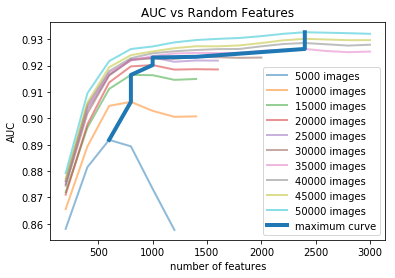

In [31]:
Plot_AUC_against_RF(train_random_features, test_random_features, y_train_bin, y_test_bin)

# Ridge on Binary

In [55]:
ridge_bin = RidgeClassifier(alpha=10)
since = time.time()
ridge_bin.fit(X_train_bin[:num_raw_img], y_train_bin[:num_raw_img])
ridge_bin_time = time.time() - since
print('Time for score: {:.4f} s'.format(ridge_bin_time))

Time for score: 8.6608 s


In [56]:
train_accuracy_bin = np.array(ridge_bin.score(X_train_bin[:100000], y_train_bin[:100000]))
test_accuracy_bin = np.array(ridge_bin.score(X_test_bin, y_test_bin))
#score_time = time.time() - since
#print('Time for score: {:.4f} s'.format(score_time))
print('Train accuracy (%): {:.4f}'.format(train_accuracy_bin*100))
print('Test accuracy (%): {:.4f}'.format(test_accuracy_bin*100))

Train accuracy (%): 100.0000
Test accuracy (%): 76.1870


In [57]:
test_output = ridge_bin.decision_function(X_test_bin)
fpr_bin, tpr_bin, thresholds = metrics.roc_curve(y_test_bin,test_output,sample_weight=weights_test)

Text(0.5, 1.0, 'ROC Curve with only binary data')

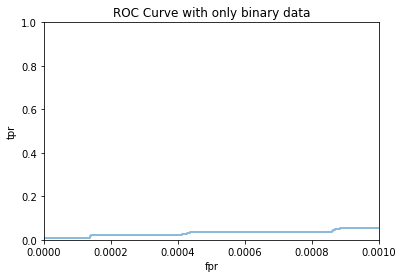

In [58]:
pyplot.plot(fpr_bin, tpr_bin, lw=2,alpha=0.5)
pyplot.axis((0,.001,0,1))
pyplot.xlabel("fpr")
pyplot.ylabel("tpr")
pyplot.title("ROC Curve with only binary data")
#pyplot.savefig("ROC Curve 50000 with binarized data but without random features")

In [59]:
metrics.auc(fpr_bin, tpr_bin)

0.8109776663665389

# Ridge on raw image

In [46]:
import h5py

In [47]:
filename = '../Data/train.h5'
f = h5py.File(filename, 'r')

In [61]:
X_train = np.expand_dims(f['all_events']['hist'][:], -1)
y_train = np.expand_dims(f['all_events']['y'][:], -1)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])

In [69]:
train_size = .75
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=train_size)

In [71]:
ridge_raw = RidgeClassifier(alpha=10)
#since = time.time()
ridge_raw.fit(X_train, y_train)

/data1/alpha/biswajit-biswas/opu-venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RidgeClassifier(alpha=10, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [72]:
train_accuracy_raw = ridge_raw.score(X_train, y_train)
test_accuracy_raw = ridge_raw.score(X_test, y_test)
#score_time = time.time() - since
#print('Time for score: {:.4f} s'.format(score_time))
print('Train accuracy (%): {:.4f}'.format(train_accuracy_raw*100))
print('Test accuracy (%): {:.4f}'.format(test_accuracy_raw*100))

Train accuracy (%): 75.1073
Test accuracy (%): 74.9909


In [73]:
test_output_raw = ridge_raw.decision_function(X_test)
fpr_raw, tpr_raw, thresholds = metrics.roc_curve(y_test,test_output_raw)

Text(0.5, 1.0, 'ROC Curve without OPU')

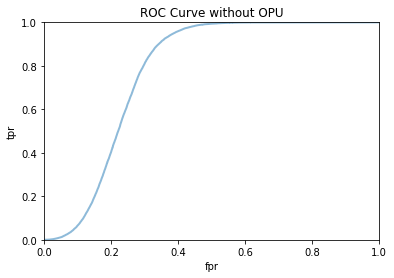

In [74]:
pyplot.plot(fpr_raw, tpr_raw, lw=2,alpha=0.5)
pyplot.axis((0,1,0,1))
pyplot.xlabel("fpr")
pyplot.ylabel("tpr")
pyplot.title("ROC Curve without OPU")
#pyplot.savefig("ROC Curve 50000 without random features and binarization")

# Compare Ridge on OPU VS BINARY

In [ ]:
AUC_binary = []
AUC_opu = []
batch_step = 5000
sample_space = []
for j in range(1,11):
    
    print(j)
    
    ridge_bin = RidgeClassifier(alpha=10)
    ridge_bin.fit(X_train_bin[:j*batch_step], y_train_bin[:j*batch_step])
    
    #ridge_opu = RidgeClassifier(alpha=10)
    #ridge_opu.fit(train_random_features[:j*batch_step], y_train_bin[:j*batch_step])

    
    test_output = ridge_bin.decision_function(X_test_bin)
    fpr_bin, tpr_bin, thresholds = metrics.roc_curve(y_test_bin,test_output)
    
    #test_output_opu = ridge_opu.decision_function(test_random_features)
    #fpr_opu, tpr_opu, thresholds = metrics.roc_curve(y_test_bin,test_output_opu)
    
    AUC_binary.append(metrics.auc(fpr_bin, tpr_bin))
    #AUC_opu.append(metrics.auc(fpr_opu,tpr_opu))
    
    sample_space.append(j*batch_step)


In [ ]:
pyplot.plot(sample_space,AUC_binary,  lw=2,alpha=0.5,label="Binary")
#pyplot.plot(sample_space,AUC_opu,lw=2 , alpha=.5,label="OPU")
pyplot.title("AUC curve for binary data")
pyplot.xlabel("number of images")
pyplot.ylabel("AUC")